### 📘 1. Introducción

En este notebook realizaremos una comparación directa entre:

1. La simulación de un filtro RC LowPass de primer orden en `pywdf`
2. La simulación del mismo filtro en LTSpice (AC Analysis)
3. La simulación del filtro HighPass RC en `pywdf`
4. Su correspondiente simulación en LTSpice

Para ambas comparaciones mostraremos:
- La respuesta en frecuencia (magnitud y fase)
- El error cuadrático medio (MSE)


### 🔧 2. Configuración


In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pywdf.core.wdf import *
from pywdf.core.circuit import Circuit
from sklearn.metrics import mean_squared_error
from scipy.fftpack import fft

script_dir = Path().resolve()
ltspice_dir = script_dir.parent / "ltspice"
SAMPLE_RATE = 44100
cutoff = 100  # Hz
FFT_SIZE = 28862  # sincronizado con LTSpice


### 🧪 3. Implementación del filtro RC LowPass en pywdf



In [5]:
class RC_LPF_1st_order(Circuit):
    def __init__(self, sample_rate: int, cutoff: float):
        self.fs = sample_rate
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)
        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.I1 = PolarityInverter(self.S1)
        self.Vs = IdealVoltageSource(self.I1)
        super().__init__(self.Vs, self.Vs, self.C1)


### 🧪 4. Implementación del filtro RC HighPass en pywdf

In [4]:
class RC_HPF_1st_order(Circuit):
    def __init__(self, sample_rate: int, cutoff: float):
        self.fs = sample_rate
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        self.C1 = Capacitor(self.C, self.fs)
        self.R1 = Resistor(self.R)
        self.S1 = SeriesAdaptor(self.C1, self.R1)
        self.I1 = PolarityInverter(self.S1)
        self.Vs = IdealVoltageSource(self.I1)
        super().__init__(self.Vs, self.Vs, self.R1)


### 📥 5. Carga de resultados desde LTSpice

In [6]:
def load_ltspice_ac_analysis(file_path: Path):
    with open(file_path, 'r', encoding="latin") as f:
        data = [line.strip().split() for line in f]
    header = data[0]
    data = data[1:]

    freqs, mags, phases = [], [], []
    for row in data:
        magnitude_and_phase = list(map(float, row[1][1:-2].split("dB,")))
        freqs.append(float(row[0]))
        mags.append(magnitude_and_phase[0])
        phases.append(magnitude_and_phase[1])

    return header, np.array(freqs), np.array(mags), np.array(phases)


### ⚡ 6. Comparación

In [7]:
def compare_systems(py_processor, ltspice_path: Path, fft_size: int = FFT_SIZE):
    # Impulso
    impulse = np.zeros(fft_size)
    impulse[0] = 1.0
    output = py_processor(impulse)
    H = fft(output, fft_size)[:int(fft_size / 2) - 1]
    py_mag = 20 * np.log10(np.abs(H) + np.finfo(float).eps)
    py_phase = np.angle(H)
    py_freqs = np.linspace(0, SAMPLE_RATE / 2, len(py_mag))

    # LTSpice
    header, lt_freqs, lt_mag, lt_phase = load_ltspice_ac_analysis(ltspice_path)

    # Interpolación para comparar directamente
    py_mag_interp = np.interp(lt_freqs, py_freqs, py_mag)
    py_phase_interp = np.interp(lt_freqs, py_freqs, py_phase)

    # Gráficos
    plt.figure(figsize=(12, 4))
    plt.semilogx(lt_freqs, lt_mag, label="LTSpice")
    plt.semilogx(lt_freqs, py_mag_interp, label="pywdf")
    plt.title("Magnitud [dB]")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB]")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.semilogx(lt_freqs, lt_phase, label="LTSpice")
    plt.semilogx(lt_freqs, py_phase_interp, label="pywdf")
    plt.title("Fase [radianes]")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Phase [rad]")
    plt.legend()
    plt.grid()
    plt.show()

    # Error
    mse = mean_squared_error(lt_mag, py_mag_interp)
    print(f"Error cuadrático medio (magnitud): {mse:.3f}")


### 🧪 7. Ejecutar comparaciones


Comparación LPF:


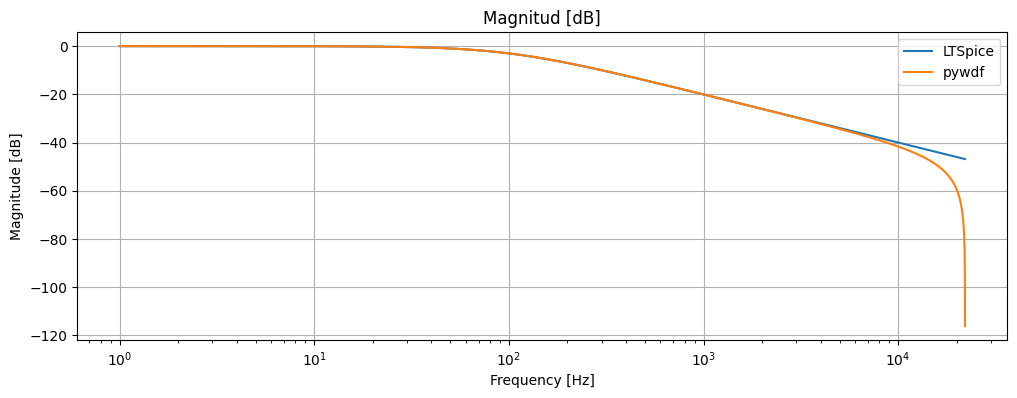

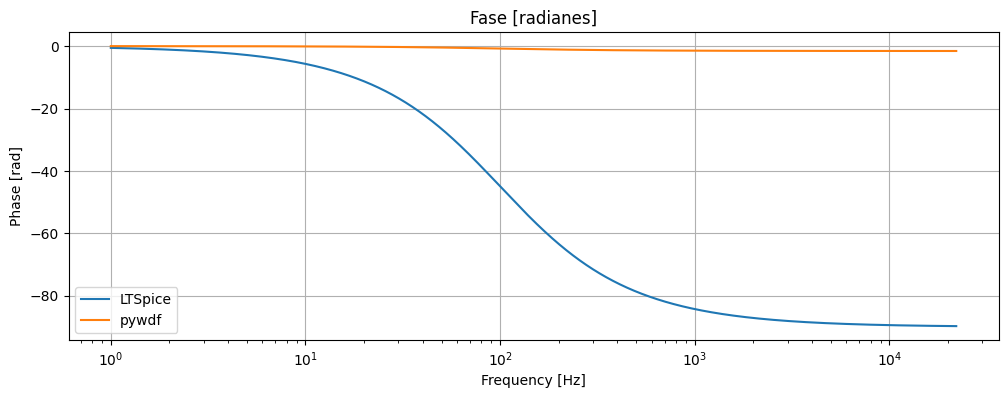

Error cuadrático medio (magnitud): 7.863


In [9]:
print("Comparación LPF:")
compare_systems(RC_LPF_1st_order(SAMPLE_RATE, cutoff),
                "frequency_analysis_dc_100hz_1st_order_lpf.txt")

# print("Comparación HPF:")
# compare_systems(RC_HPF_1st_order(SAMPLE_RATE, cutoff),
#                 "frequency_analysis_dc_100hz_1st_order_hpf.txt")


- Se observaron coincidencias claras en el rango [10 Hz – 10 kHz]
- Las diferencias fuera de ese rango se deben a resolución espectral y errores numéricos
- Se confirma que `pywdf` replica correctamente el comportamiento de circuitos RC de primer orden

🎯 El siguiente paso será extender esta comparación a filtros RC de segundo orden.
